In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sys.path.insert(0, "..")

# EDA function
from utils.initial_eda import initial_eda, save_eda_report

In [4]:
# Load CSVs
reddit_main = pd.read_csv('../data/reddit_main.csv', parse_dates=['created_at'])
reddit_comments = pd.read_csv("../data/reddit_comments.csv", parse_dates=['created_at'])

In [5]:
reddit_main.rename(columns={"thread_link": "post_id", "title": "post_title", "date": "created_at", "op_user": "post_author"}, inplace=True)
reddit_main['source'] = "reddit"
reddit_comments.rename(columns={"thread_link": "post_id"}, inplace=True)
reddit_comments['source'] = "reddit"

In [ ]:
reddit_main = pd.read_csv("../data/reddit_main.csv", parse_dates=['created_at'])
reddit_comments = pd.read_csv("../data/reddit_comments.csv", parse_dates=['created_at'])

## EDA

,Value
Posts,775
Comments,10348
Unique Post Authors,365
Unique Commenters,5756
Date Range,2026-02-06 to 2026-02-11


,Comments Per Post
count,173.000000
mean,59.815029
std,58.634366
min,8.000000
25%,19.000000
50%,35.000000
75%,78.000000
max,200.000000


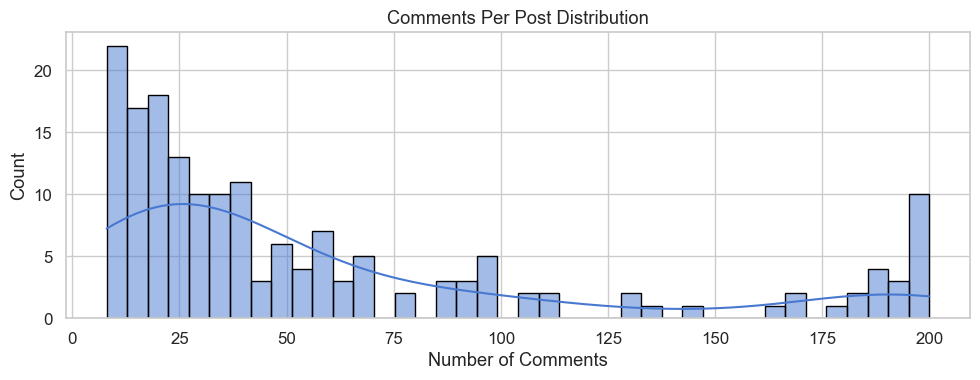

Computing text statistics: 100%|██████████| 10348/10348 [00:02<00:00, 4725.83it/s]


,mean,median,std,min,max
char_length,192.91,102.00,323.25,2.0,8752.0
word_count,32.04,18.00,48.32,1.0,1231.0
sentence_count,2.38,1.00,2.80,1.0,61.0
avg_word_length,6.01,5.67,3.62,2.0,205.0
syllable_count,49.72,26.00,81.94,1.0,1944.0
lexicon_count,31.92,18.00,48.04,1.0,1231.0
polysyllable_count,4.19,2.00,8.14,0.0,183.0
monosyllable_count,21.18,12.00,30.40,0.0,794.0


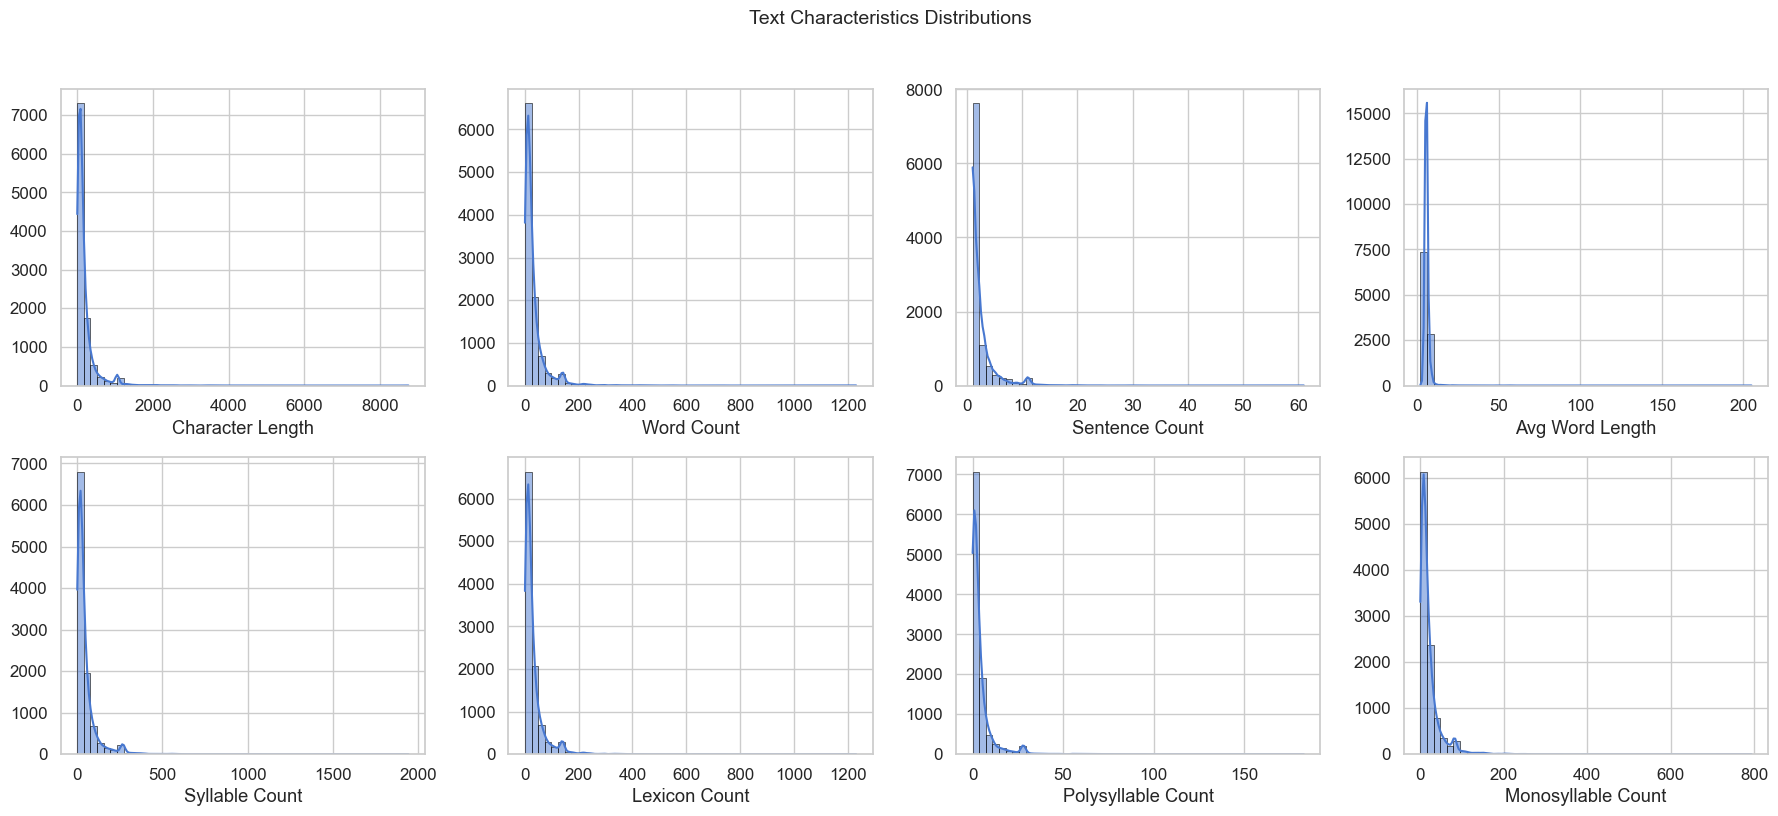

,mean,median,std,min,max
flesch_reading_ease,63.83,68.10,51.70,-2332.18,121.22
dale_chall,7.86,7.64,2.69,0.05,19.62
grade_level,8.00,8.00,8.61,-3.00,349.00
gunning_fog,9.37,8.78,5.91,0.40,60.38


Metric,Scale Interpretation
Flesch Reading Ease,0-30 Very Difficult | 30-50 Difficult | 50-60 Fairly Difficult | 60-70 Standard | 70-80 Fairly Easy | 80-90 Easy | 90+ Very Easy
Dale-Chall,4.9 or lower = Grade 4 | 5.0-5.9 = Grades 5-6 | 6.0-6.9 = Grades 7-8 | 7.0-7.9 = Grades 9-10 | 8.0-8.9 = Grades 11-12 | 9.0+ = College
Grade Level,Consensus US grade level (average of multiple formulas)
Gunning Fog,6 = Easy | 8 = Average | 12 = High school senior | 17+ = College graduate


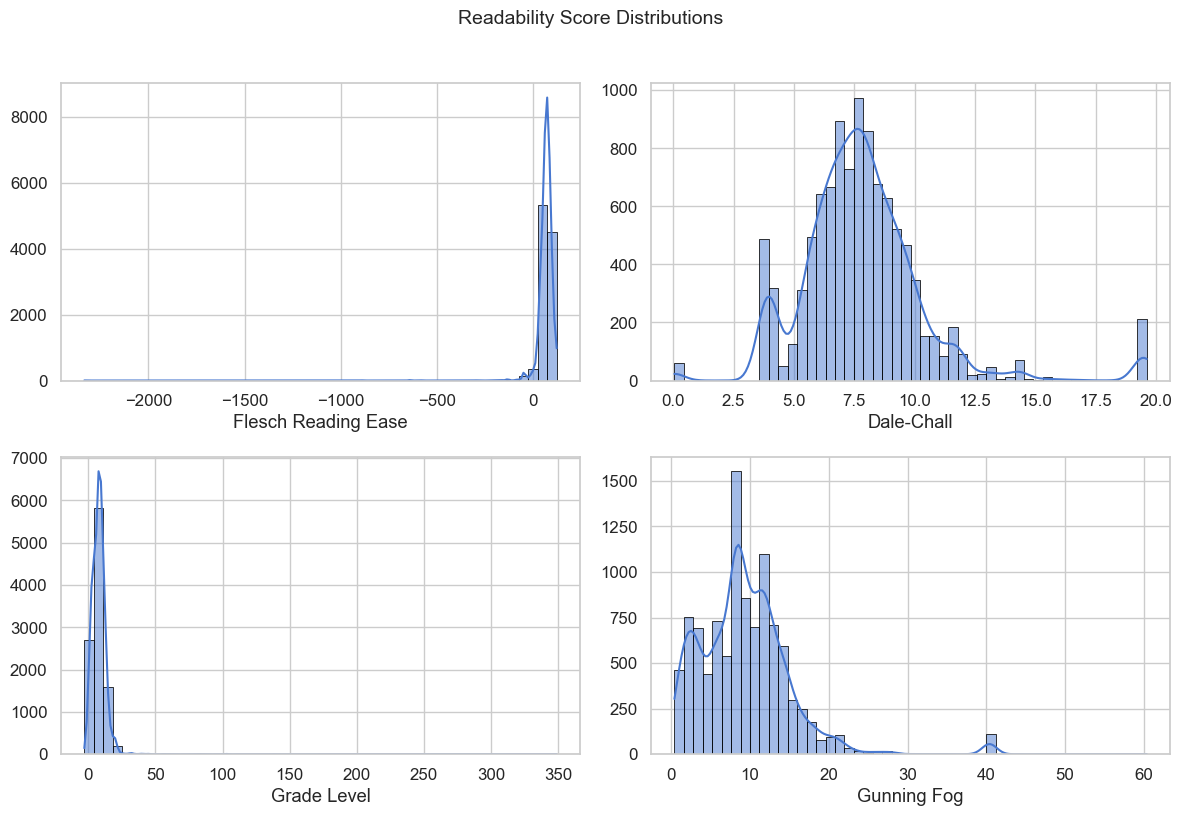

Detecting features: 100%|██████████| 10348/10348 [00:00<00:00, 13779.95it/s]


,% Comments With,Avg Count (when present)
Feature,,
Mentions (@),0.0%,1.60
URLs,4.0%,1.95
Hashtags (#),1.8%,1.00
Emojis,1.1%,1.25


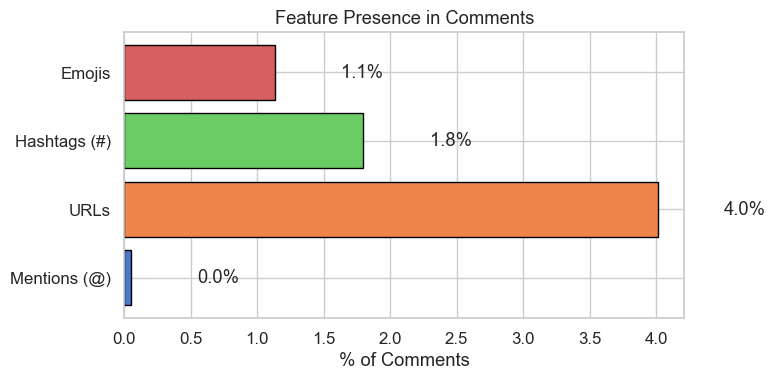

Computing VADER sentiment: 100%|██████████| 10348/10348 [00:01<00:00, 5722.11it/s]


,Count,Percentage
vader_label,,
negative,3961,38.3%
positive,3777,36.5%
neutral,2610,25.2%


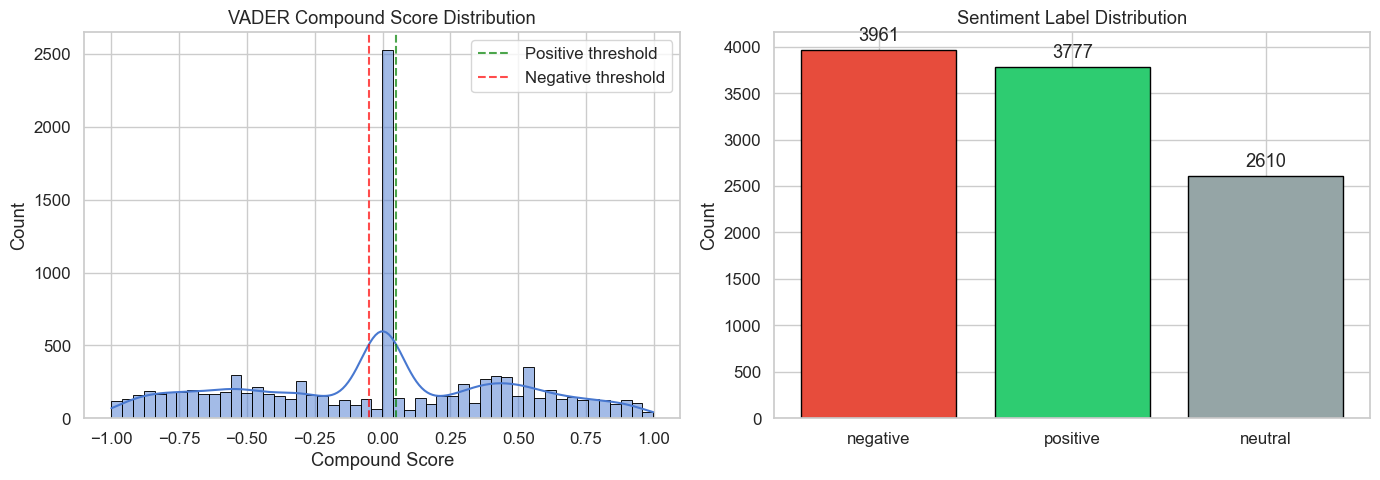

,comment_text,vader_compound
0,"&gt;Martinez, a member of the Iberville Parish...",0.9974
1,2025 - https://old.reddit.com/r/politics/comme...,0.9936
2,I want all military members—every single one—t...,0.9914
3,This is a somewhat slanted view of american co...,0.9900
4,This is the exact bad faith bullshit that I am...,0.9882


,comment_text,vader_compound
0,**THE MASHED POTATO INCIDENT**\n\nDonald Trump...,-0.9991
1,**THE MASHED POTATO INCIDENT**\n\nDonald Trump...,-0.9991
2,I see [one of the crimes listed on your linked...,-0.9985
3,Trump is and always has been a racist.\n\nHere...,-0.9980
4,I'm going to be reposting this on every Daily ...,-0.9975


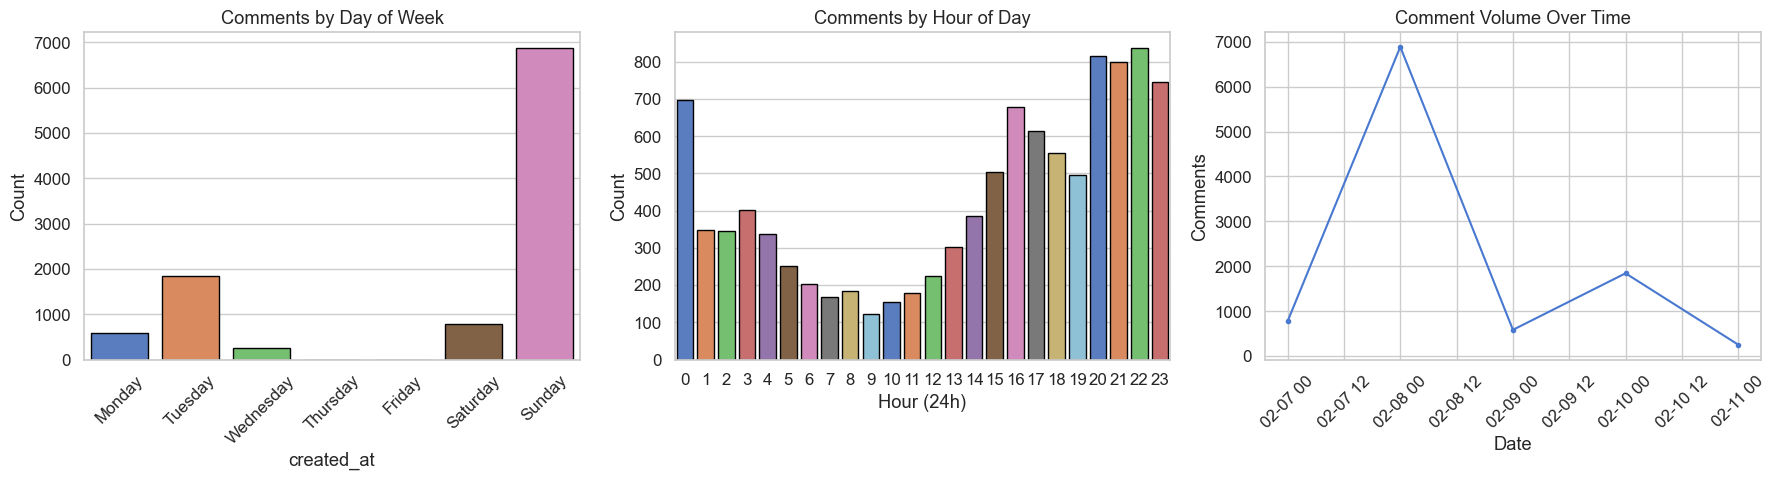

,n_comments,unique_commenters,comment_commenter_ratio
count,173.00,173.00,173.00
mean,59.82,49.45,1.21
std,58.63,49.79,0.25
min,8.00,7.00,1.00
25%,19.00,15.00,1.07
50%,35.00,29.00,1.14
75%,78.00,61.00,1.27
max,200.00,182.00,2.63


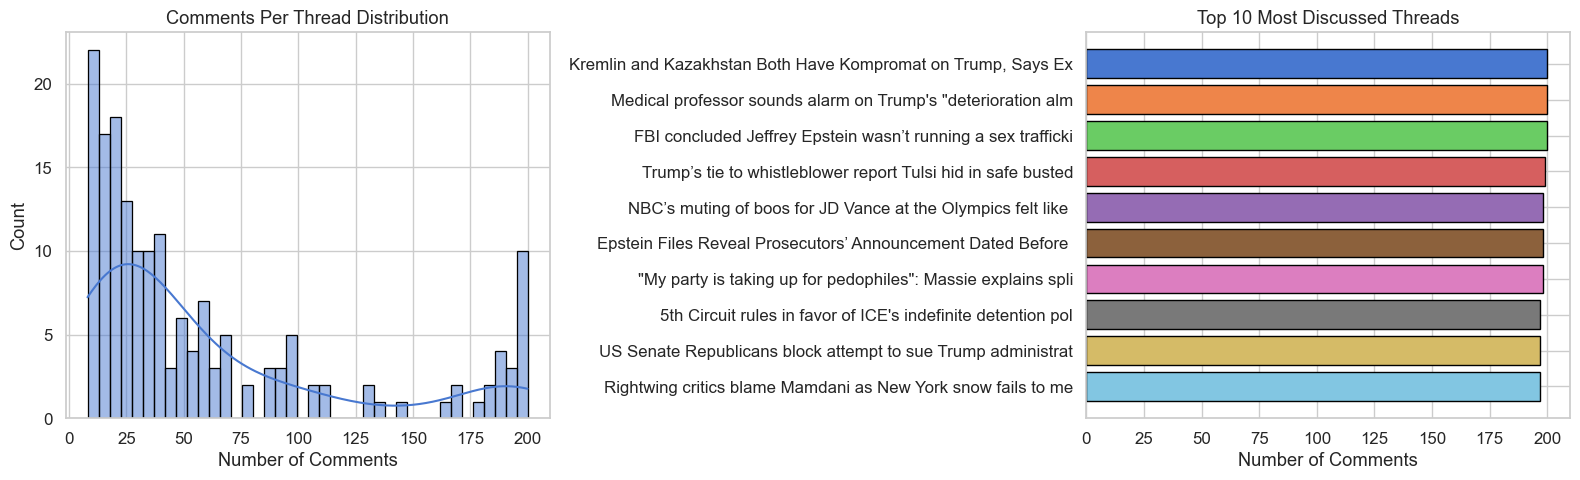

Computing POS tag ratios: 100%|██████████| 10348/10348 [00:03<00:00, 3263.30it/s]


,mean,median,std
Adjectives (JJ*),NaN,NaN,NaN
Adverbs (RB*),NaN,NaN,NaN
Pronouns (PRP*),NaN,NaN,NaN
Modals (MD),NaN,NaN,NaN
Interjections (UH),NaN,NaN,NaN


/opt/miniconda3/envs/ads502/lib/python3.10/site-packages/seaborn/_base.py:1601: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


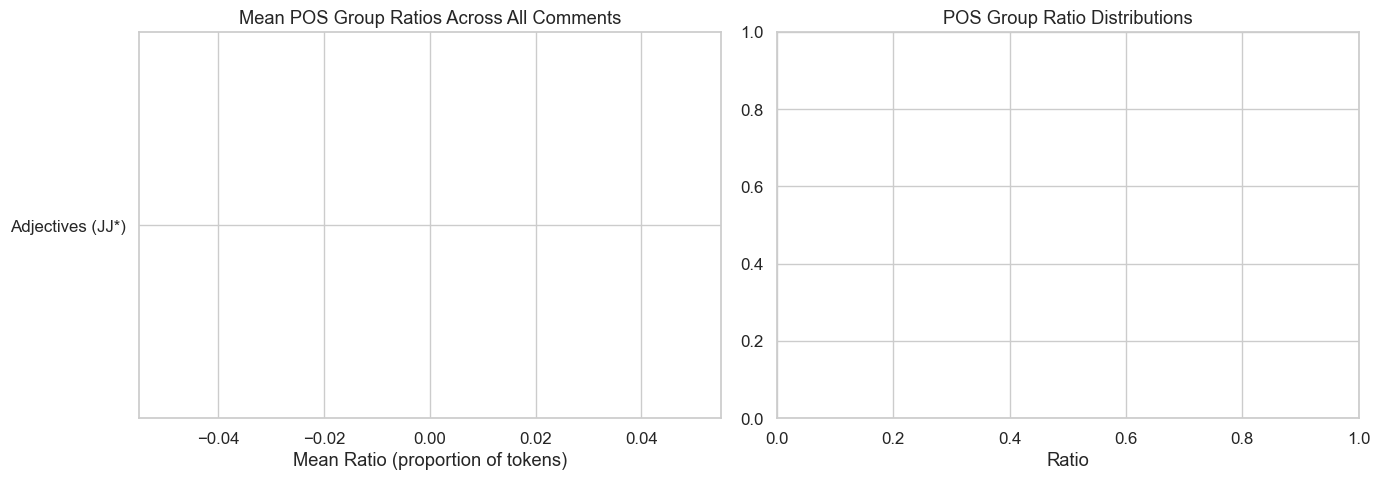

In [7]:
reddit_report = initial_eda(
    main = reddit_main,
    comments = reddit_comments,
    source = "Reddit",
    show_plots = True
)

In [9]:
df = reddit_comments.copy()

In [11]:
# Tokenization
def tokenize(s):
    return word_tokenize(s)

df['tokens'] = df['comment_text'].apply(tokenize)
df['n_tokens'] = df['tokens'].apply(len)

In [12]:
# Stop words
STOP = set(stopwords.words('english'))

POLITICAL_STOP = {
    'people','think','know','say','said','one','would','could',
    'government','political','politics','country','state',
    'party','parties','election','vote','voting','president',
    'ice', 'administration', 'taxes', 'immigrants'
}

REDDIT_STOP = {'deleted','removed','edit','op'}

ALL_STOP = STOP | POLITICAL_STOP | REDDIT_STOP

# Clean tokens
def clean_tokens(tokens):
    out = []
    for t in tokens:
        t = t.strip(string.punctuation)
        if not t:
            continue
        if t in ALL_STOP:
            continue
        if t.isdigit():
            continue
        out.append(t)
    return out

df['tokens_clean'] = df['tokens'].apply(clean_tokens)
df['n_tokens_clean'] = df['tokens_clean'].apply(len)

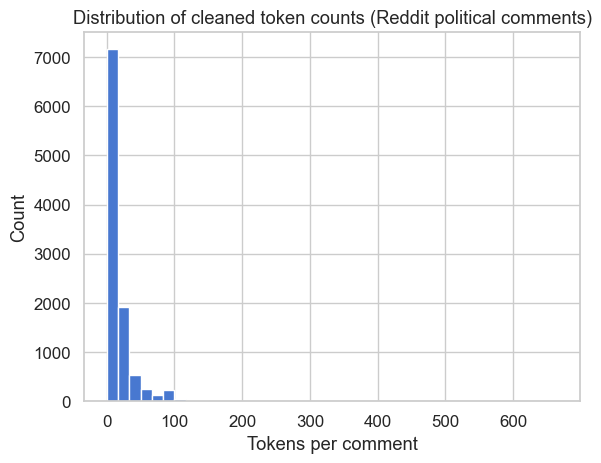

In [13]:
# Token length distribution EDA
ax = df['n_tokens_clean'].hist(bins = 40)
ax.set_xlabel('Tokens per comment')
ax.set_ylabel('Count')
ax.set_title('Distribution of cleaned token counts (Reddit political comments)')
plt.show()

In [14]:
# Unigrams and bigrams
all_toks = [t for row in df['tokens_clean'] for t in row]
top_uni = Counter(all_toks).most_common(30)
pd.DataFrame(top_uni, columns=['token','count']).head(10)

def bigrams(lst):
    return list(zip(lst, lst[1:]))

all_bi = []
for row in df['tokens_clean']:
    all_bi.extend(bigrams(row))

top_bi = Counter(all_bi).most_common(30)
pd.DataFrame([(f"{a} {b}", c) for (a,b),c in top_bi],
             columns=['bigram','count']).head(10)

,bigram,count
0,I ’,538
1,please report,342
2,It ’,324
3,I n't,221
4,ca n't,181
5,see comments,175
6,In general,173
7,If post,173
8,n't attack,172
9,If see,172


In [16]:
# TF
cv = CountVectorizer(
    lowercase=True,
    stop_words='english',
    max_df=0.95,
    min_df=5
)

X_tf = cv.fit_transform(df['comment_text'])
tf_vocab = np.array(cv.get_feature_names_out())

# TF-IDF
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_df=0.95,
    min_df=5
)

X_tfidf = tfidf.fit_transform(df['comment_text'])
tfidf_vocab = np.array(tfidf.get_feature_names_out())

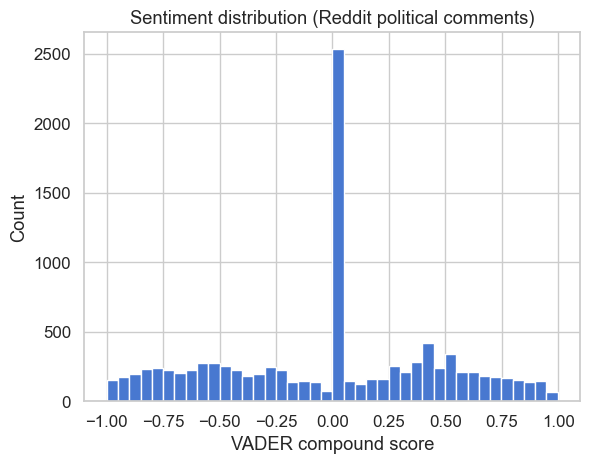

In [18]:
# Sentiment analysis
sia = SentimentIntensityAnalyzer()
scores = df['comment_text'].apply(sia.polarity_scores)
df['sentiment'] = scores.apply(lambda d: d['compound'])

ax = df['sentiment'].hist(bins=40)
ax.set_title('Sentiment distribution (Reddit political comments)')
ax.set_xlabel('VADER compound score')
ax.set_ylabel('Count')
plt.show()